In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import inspect
import pandas as pd
import copy
import seaborn as sns

import matplotlib
import matplotlib.font_manager as font_manager
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'
from matplotlib.colors import Normalize
from matplotlib import cm

from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_lsq_spline
from scipy.interpolate import LSQUnivariateSpline
from scipy.stats.mstats import gmean
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%pylab

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  del sys.path[0]


Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/home/rose/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
sc.__version__

'1.4.3'

In [3]:
#sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.6.21 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read('/mnt/e/MPIMG/Elkabetz/scrna/d50_organoids/gene_counts/day50_exp1_2017_merged_counts.removed_dup_genes.csv',sep=',')

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata

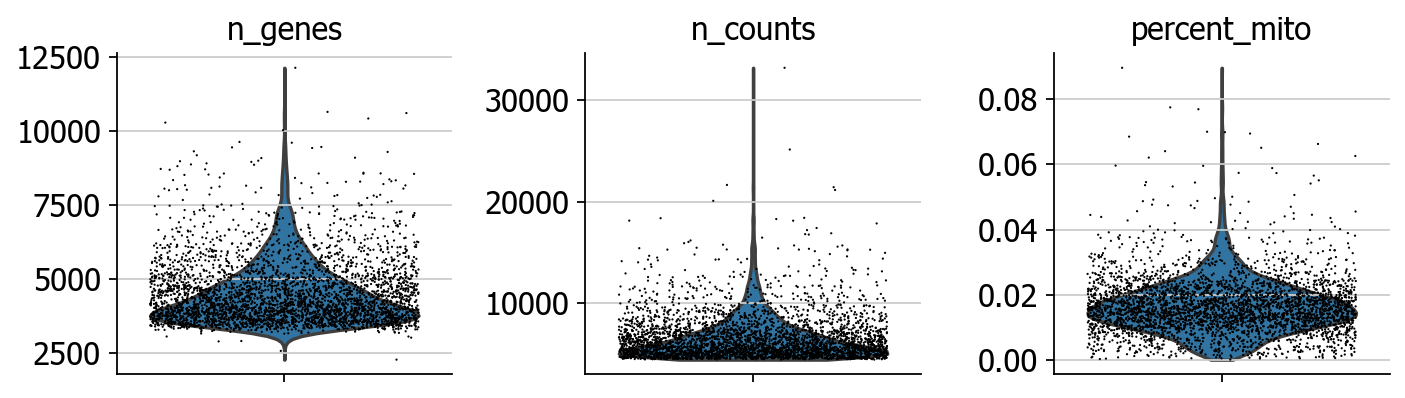

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

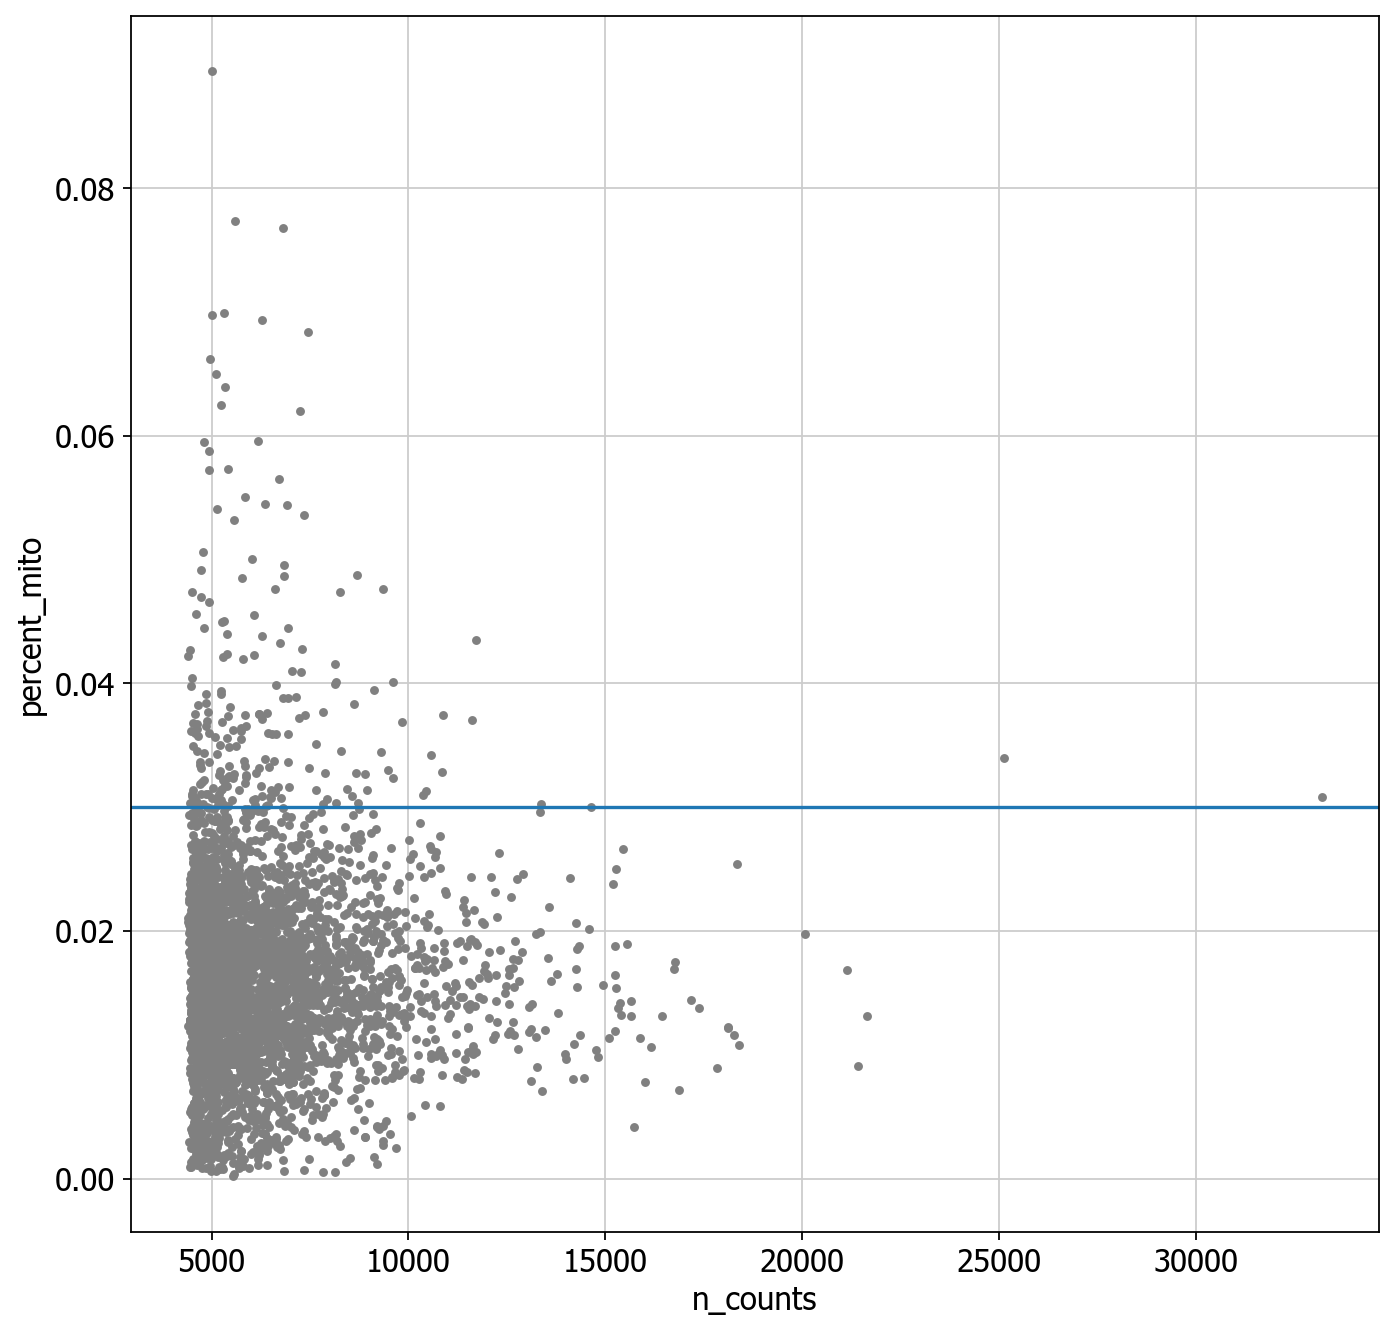

Text(0, 0.5, 'n_genes')

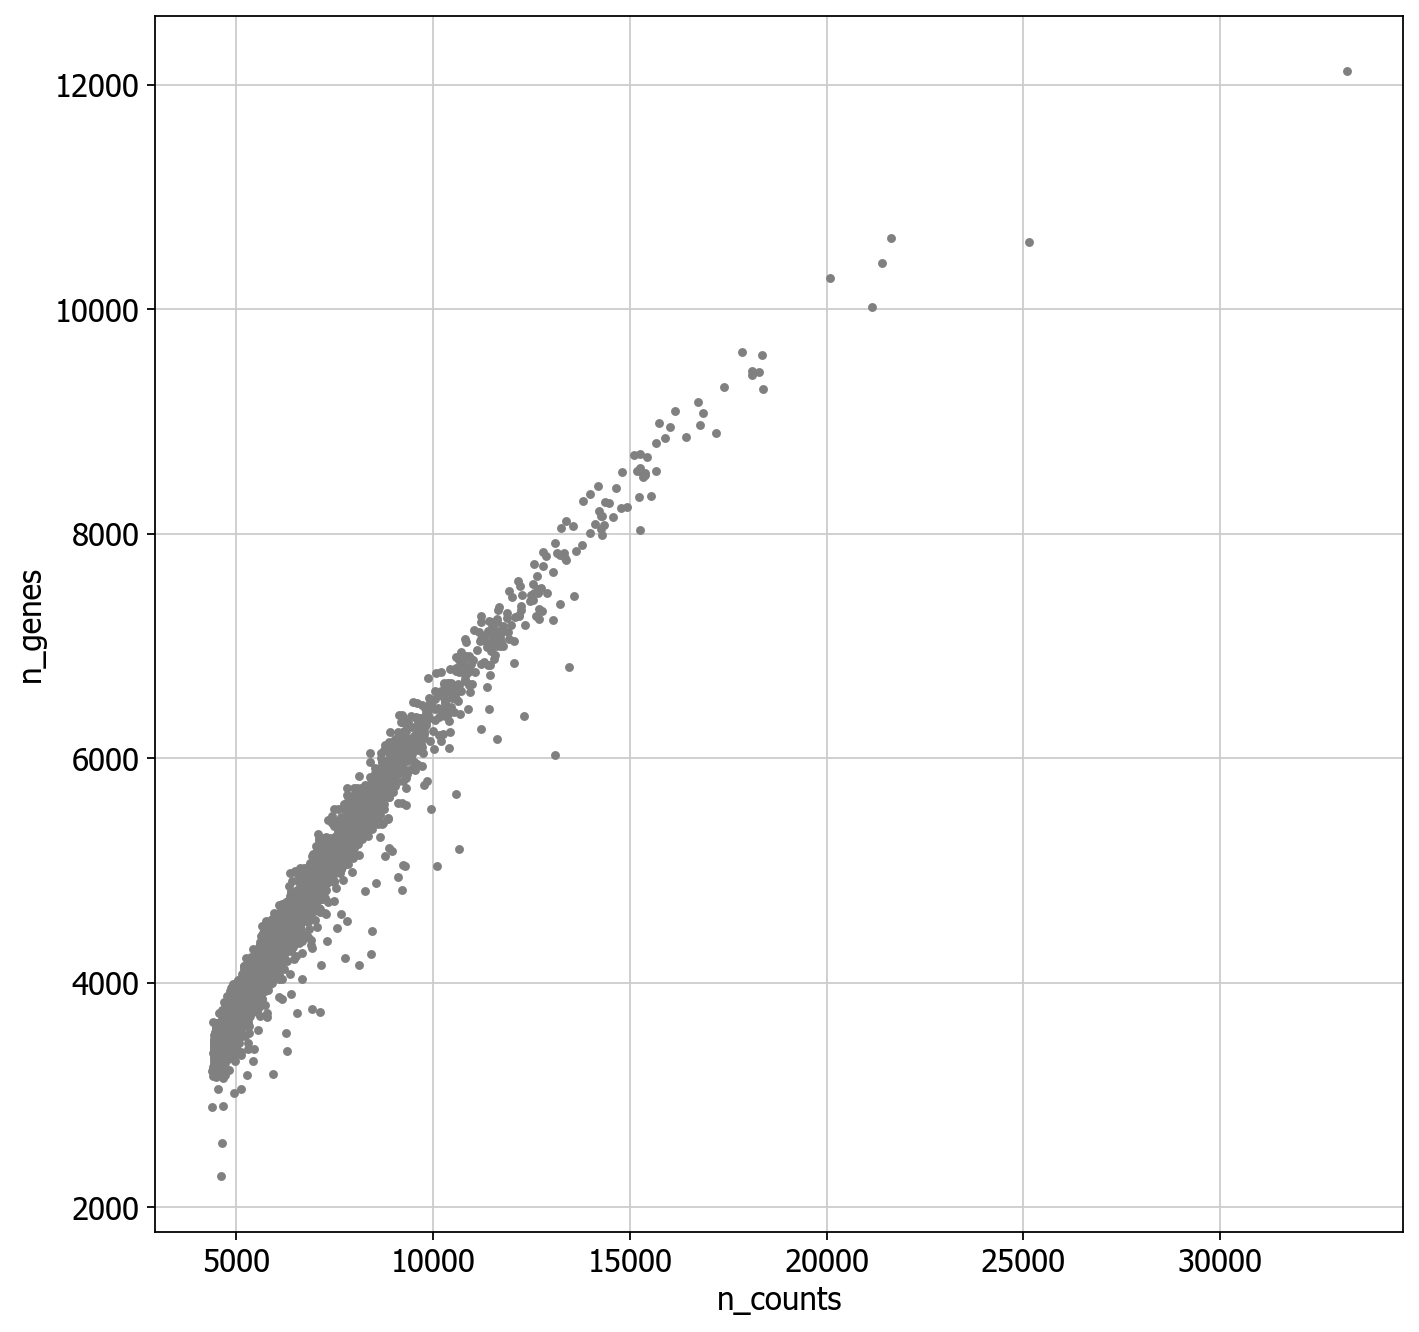

In [11]:
plt.figure(figsize=(10,10))
plt.plot(list(adata.obs['n_counts']),list(adata.obs['percent_mito']),'.',color='gray')
plt.axhline(0.03)
plt.xlabel('n_counts')
plt.ylabel('percent_mito')
plt.show()
plt.figure(figsize=(10,10))
plt.plot(list(adata.obs['n_counts']),list(adata.obs['n_genes']),'.',color='gray')
plt.xlabel('n_counts')
plt.ylabel('n_genes')

In [13]:
adata = adata[adata.obs['n_counts'] < 15000, :]
adata = adata[adata.obs['percent_mito'] < 0.03, :]
adata.obs['batch'] = [x.split("_")[0] for x in adata.obs.index]

Trying to set attribute `.obs` of view, copying.


In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata,n_bins=50)
min_mean = 0.0125
max_mean = 2
top_2000 = sorted(adata.var['dispersions_norm'][adata.var['means'] >= min_mean][adata.var['means'] <= max_mean],reverse=True)[2000]
adata.var['highly_variable'] = (adata.var['dispersions_norm'] >= top_2000) & (adata.var['means'] >= min_mean) & (adata.var['means'] <= max_mean)
adata.var[adata.var['highly_variable'] == True].sort_values(['dispersions_norm'],ascending=False)[0:50]

n_cells  highly_variable     means  dispersions  dispersions_norm
SST            178             True  0.097798     2.998829         33.256565
TTR            299             True  0.116142     2.799619         31.743532
COL1A1         632             True  0.210027     1.832555         21.310696
IGF2           928             True  0.295362     2.257614         21.036615
NPY            222             True  0.074547     1.702605         18.755653
H2BFS           56             True  0.026388     1.239586         17.340469
COL1A2         620             True  0.186444     1.239034         14.184980
RFC2           814             True  0.227770     1.227835         13.053144
TEX29          193             True  0.059764     1.116062         12.193972
LHX1           538             True  0.221777     1.083381         11.426788
GLTP          1216             True  0.347605     1.458598         11.271152
SERPINB10      528             True  0.135711     1.009778         11.146843
DLK1          1104             True  0.311380     1.210894         10.929193
TTF2          1494             True  0.416679     1.532229         10.666224
CCN2           379             True  0.116336     0.954726         10.513327
HIST1H4B       816             True  0.341150     1.365984         10.502128
NRIP3          762             True  0.223667     0.992889         10.407971
BIN3           818             True  0.217628     0.922853         10.388962
CRABP1        1084             True  0.476995     1.358103         10.067108
HIST1H4L       910             True  0.387805     1.423891          9.849043
CDKN1C         692             True  0.243371     0.936791          9.776385
DIO3           374             True  0.096906     0.852230          9.242466
HIST1H4K       845             True  0.338871     1.208711          9.196189
HIST1H4J       873             True  0.348249     1.208475          9.194235
PNPLA1         688             True  0.182759     0.808027          9.010383
HIST1H2AJ      164             True  0.065318     0.814119          8.816115
EMILIN3       1331             True  0.538616     1.457367          8.147220
UBE2C          453             True  0.141395     0.747163          8.124781
PTN            975             True  0.347999     1.070132          8.045488
ZNF503         716             True  0.245432     0.749650          7.669421
TAC3           475             True  0.157937     0.703811          7.625909
CDKN1A        1051             True  0.387906     1.108157          7.467493
HMGB2          771             True  0.262026     0.723368          7.373521
TCF7L2        1743             True  0.678340     1.668474          7.317446
RGS16          670             True  0.225146     0.714339          7.271865
FIS1           720             True  0.196977     0.647152          7.078951
TTC39B        1824             True  0.520569     1.281907          7.039370
CALB2          806             True  0.292875     0.796013          6.922981
PMF1           560             True  0.183381     0.630790          6.882503
PAN2          1005             True  0.276970     0.785703          6.823430
ADGRD1        1049             True  0.279983     0.785608          6.822506
CLDN19         927             True  0.241906     0.663554          6.700100
MT2A           685             True  0.213003     0.610182          6.635092
RRP7BP        1108             True  0.296441     0.765397          6.627345
TRAPPC2B       427             True  0.112298     0.610887          6.556580
CXCR4          761             True  0.251138     0.636581          6.396417
HIST1H2AI       90             True  0.030246     0.460974          6.386100
CCR4           543             True  0.140763     0.589826          6.314220
GADD45B        455             True  0.124322     0.582153          6.225928
ZIC1          1252             True  0.435048     0.935597          6.165895

In [16]:
genes = list(adata.var_names)
mito_genes = [gene for gene in genes if gene[:3] == 'MT-' or (gene[:2] == 'MT' and '.' in gene)]
rb_genes = [gene for gene in genes if gene[:3] in ['RNR','RPL','RPS','MRP'] or (gene[:2] == 'RP' and '.' in gene)]

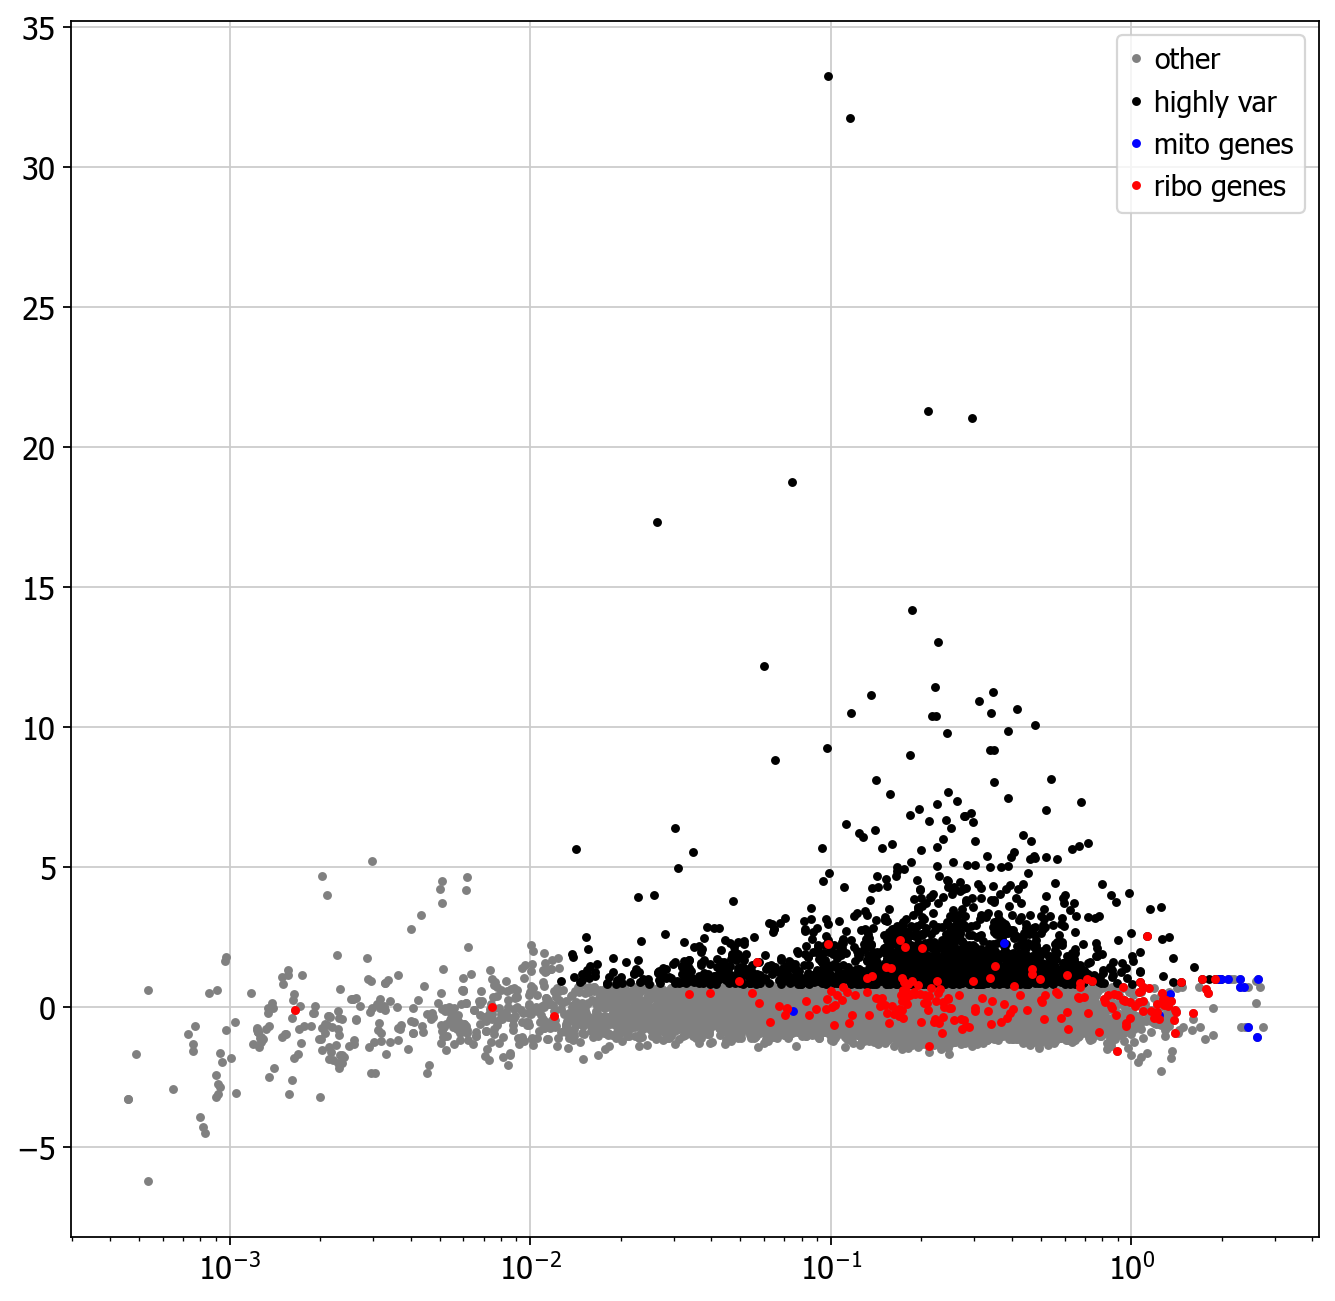

In [17]:
plt.figure(figsize=(10,10))
plt.plot(adata.var[adata.var['highly_variable'] == False]['means'],adata.var[adata.var['highly_variable'] == False]['dispersions_norm'],'.',color='gray',label='other')
plt.plot(adata.var[adata.var['highly_variable'] == True]['means'],adata.var[adata.var['highly_variable'] == True]['dispersions_norm'],'.',color='black',label='highly var')
plt.plot(adata.var.loc[mito_genes]['means'],adata.var.loc[mito_genes]['dispersions_norm'],'.',color='blue',label='mito genes')
plt.plot(adata.var.loc[rb_genes]['means'],adata.var.loc[rb_genes]['dispersions_norm'],'.',color='red',label='ribo genes')
plt.xscale('log')
plt.legend()

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

... storing 'batch' as categorical


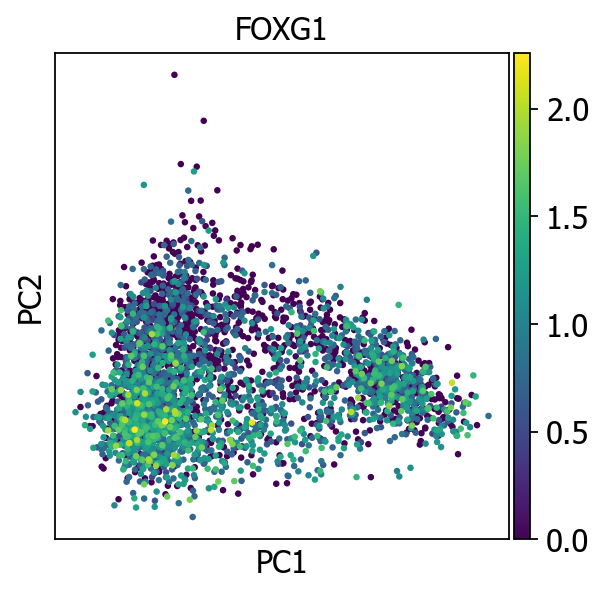

In [23]:
sc.pl.pca(adata, color='FOXG1')

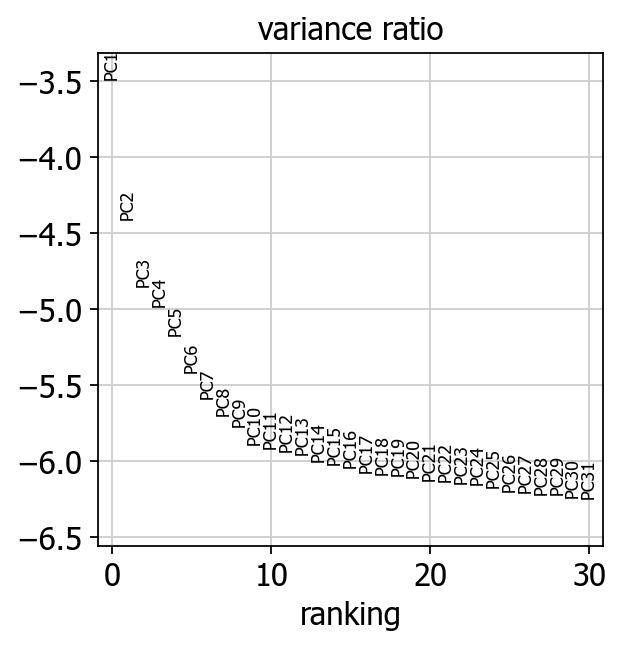

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

In [25]:
cell_cycle_genes = [x.strip() for x in open('/mnt/e/MPIMG/Elkabetz/reference_files/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [26]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


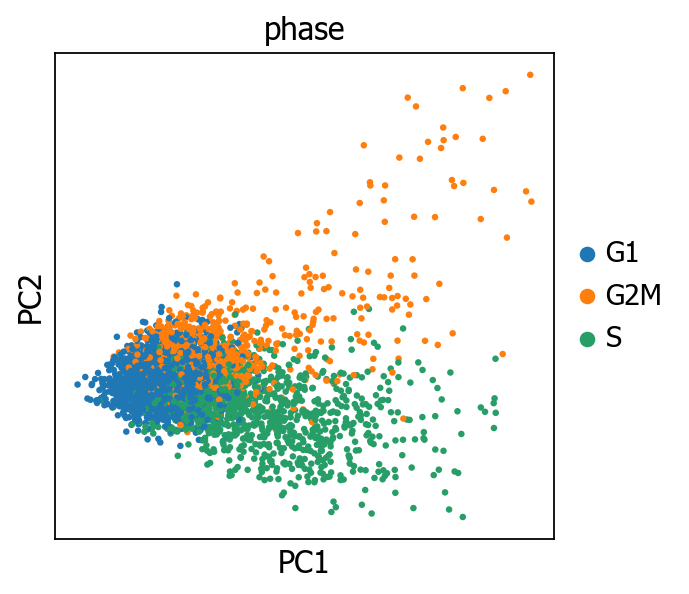

In [27]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes,use_highly_variable=False)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [28]:
sc.pp.neighbors(adata,n_pcs=12)

/home/rose/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [29]:
sc.tl.umap(adata,min_dist=0.5,spread=5)

/home/rose/.local/lib/python3.6/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [30]:
sc.tl.louvain(adata,resolution=0.6)

... storing 'phase' as categorical


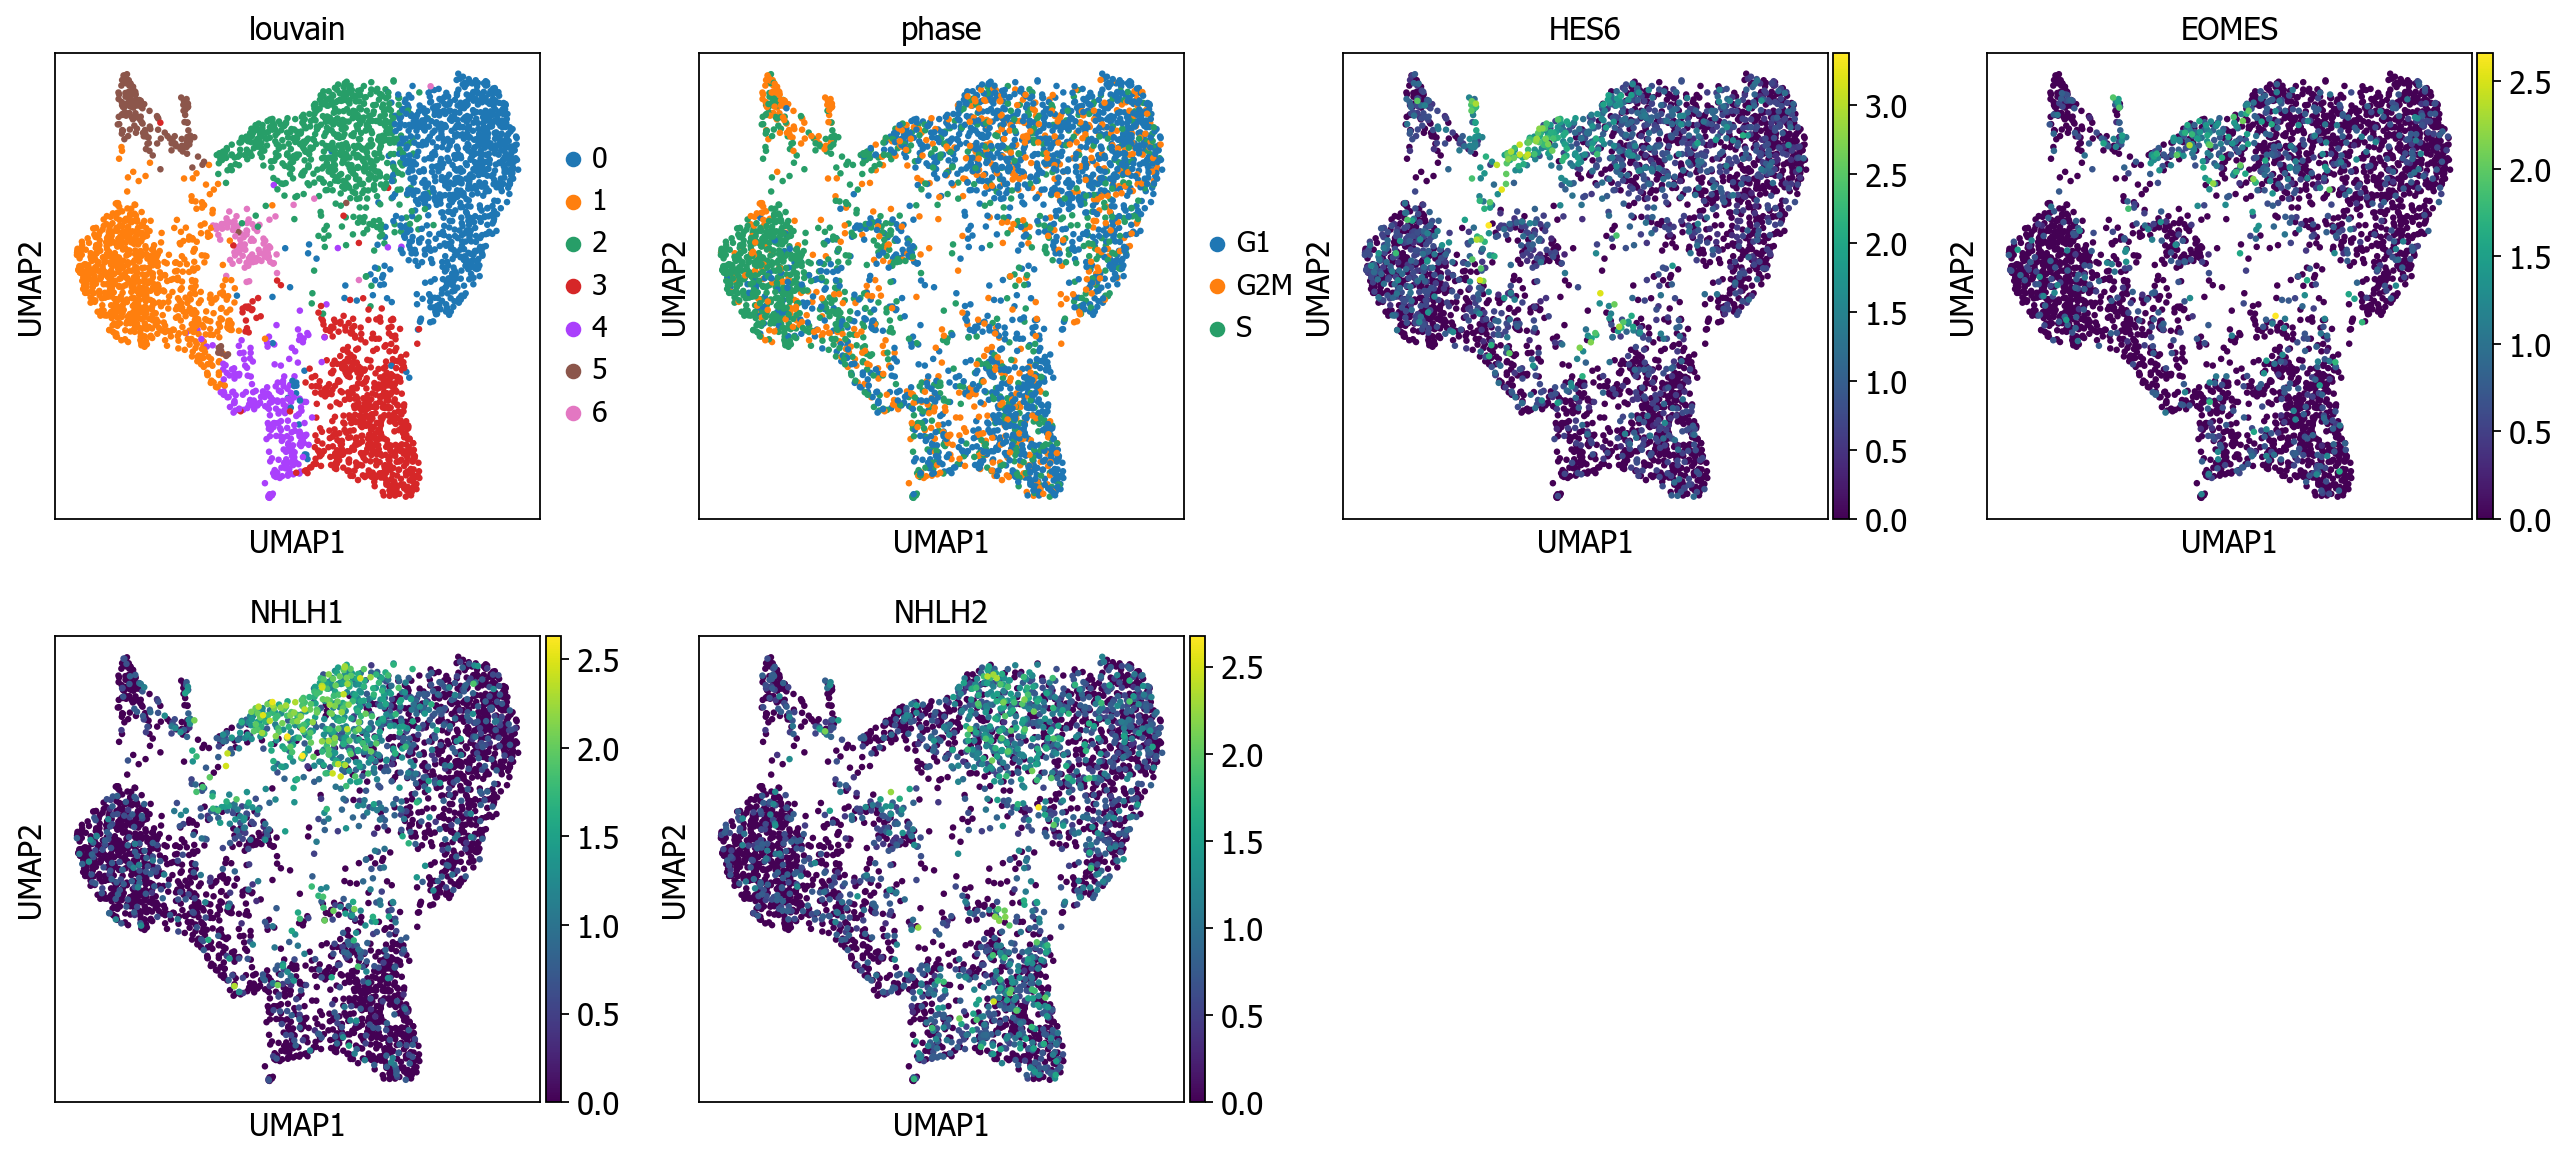

In [31]:
sc.pl.umap(adata, color=['louvain','phase','HES6','EOMES','NHLH1','NHLH2'])

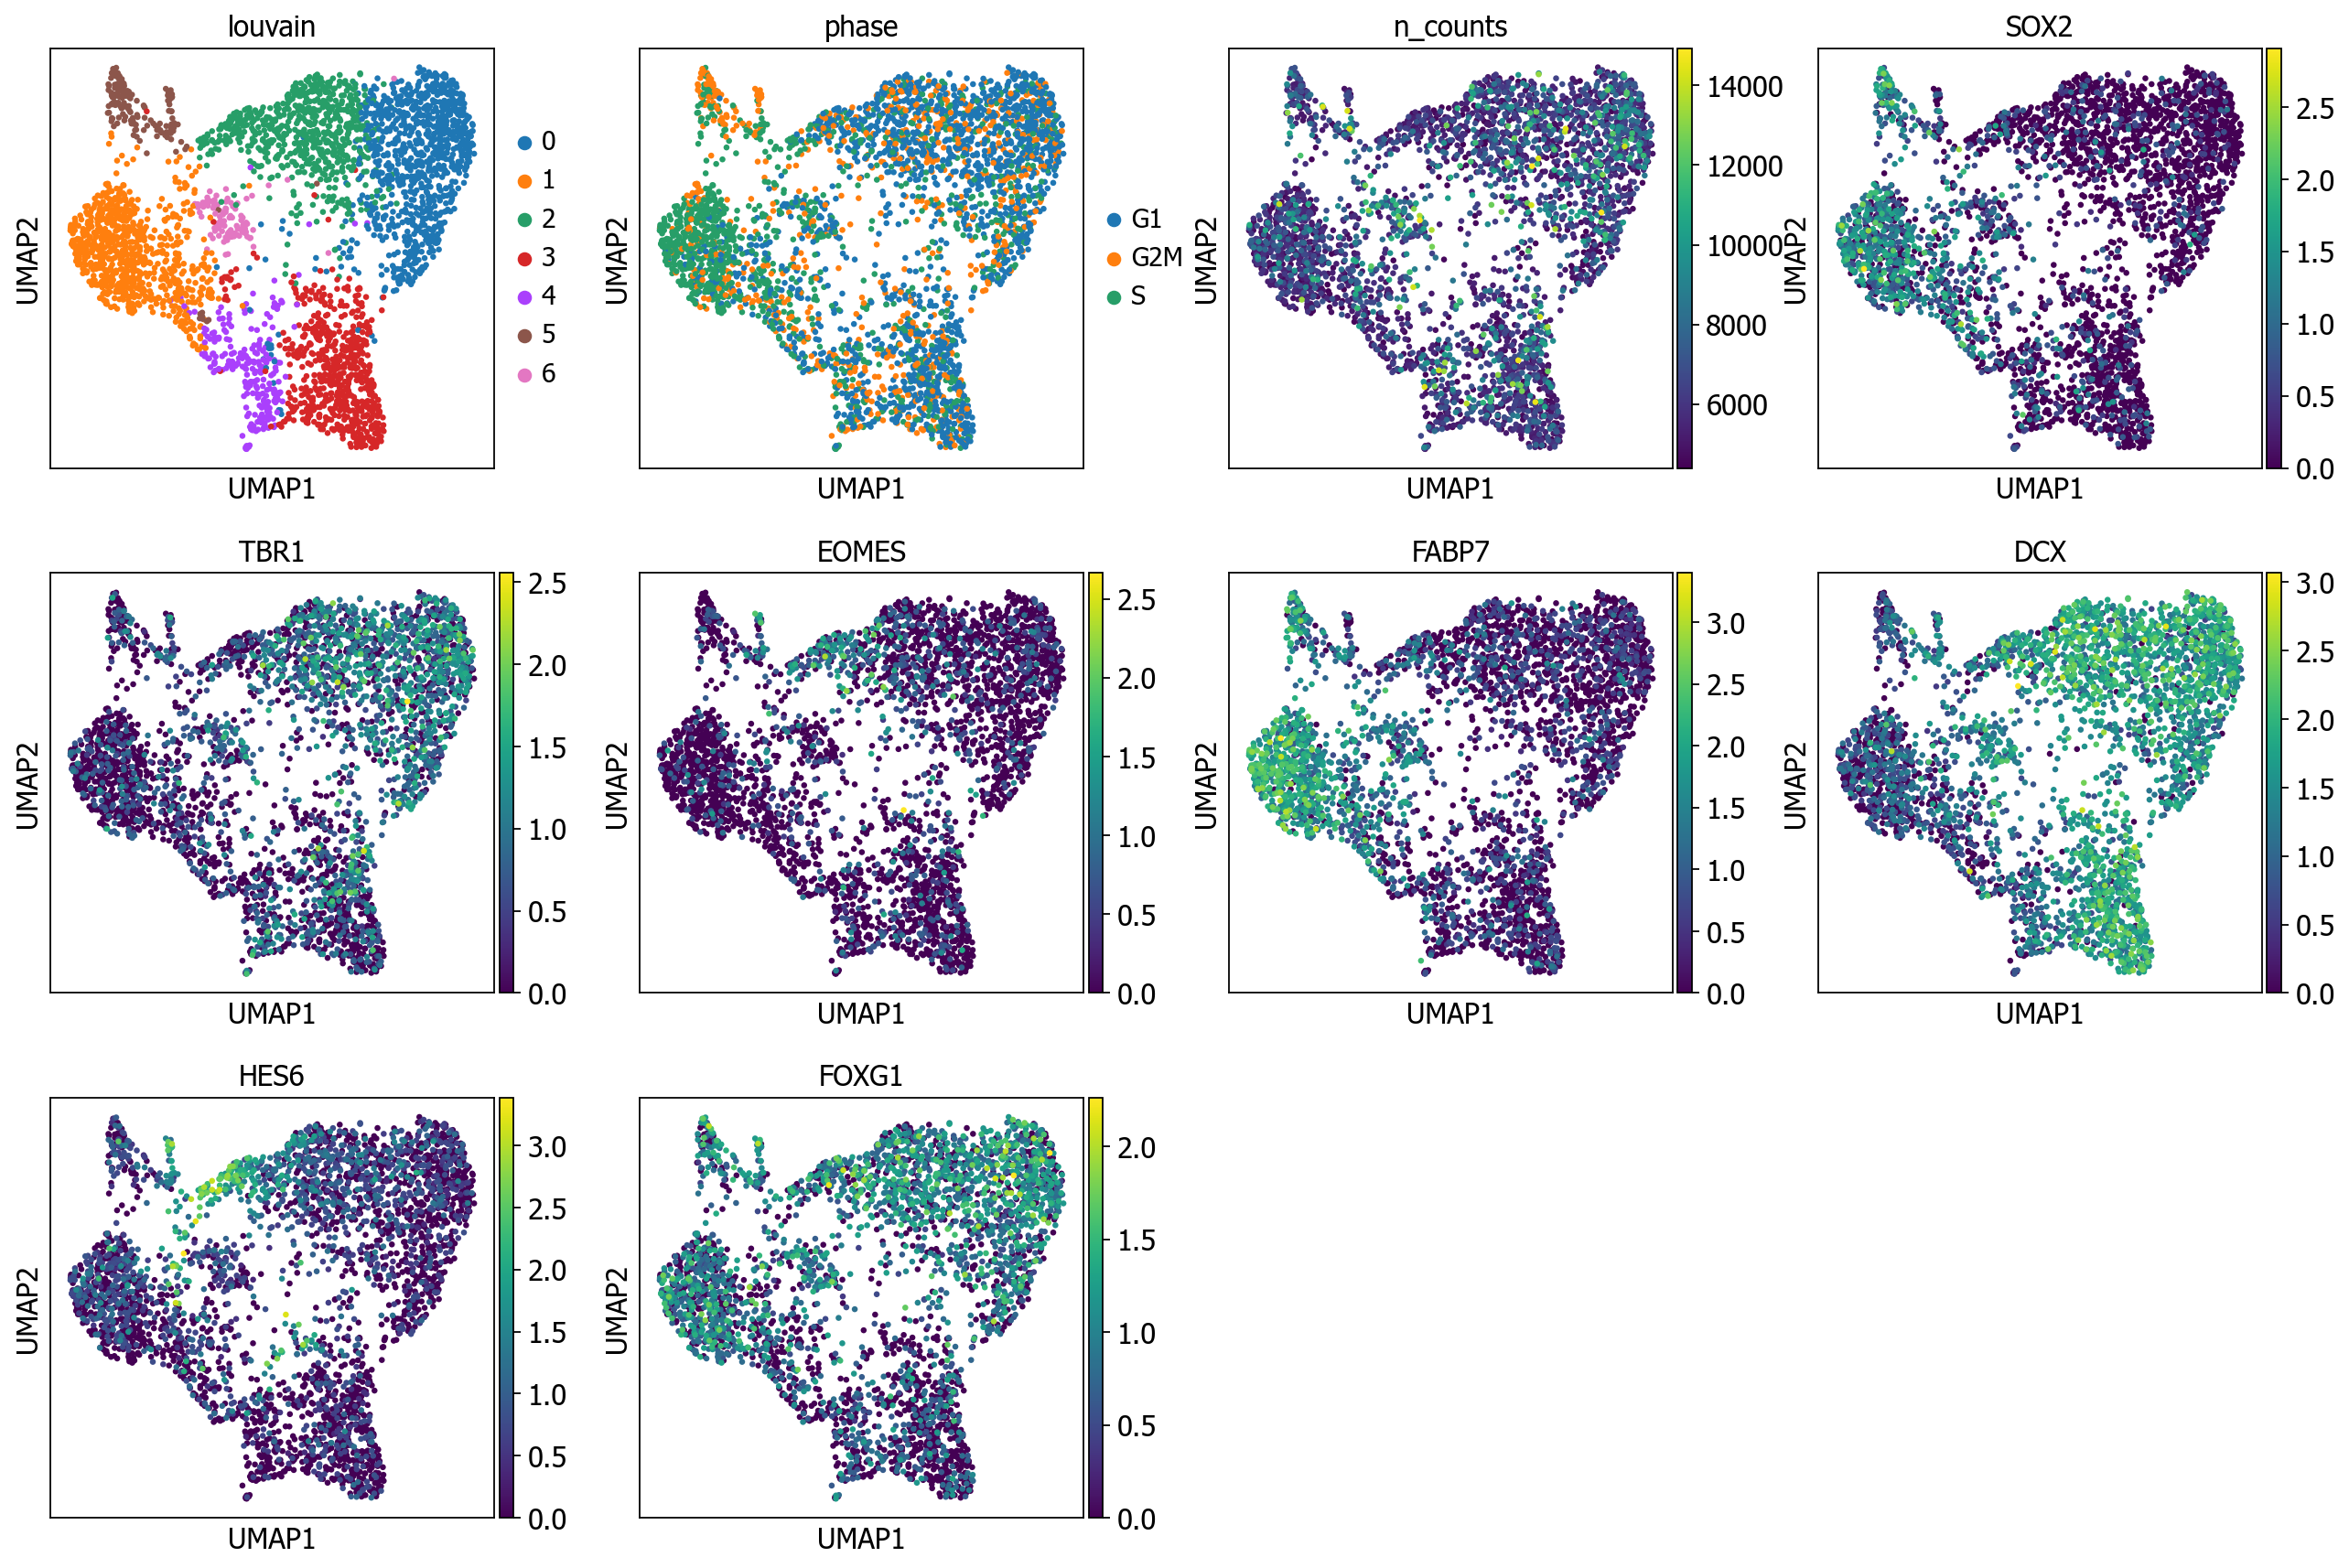

In [32]:
sc.pl.umap(adata, color=['louvain','phase','n_counts','SOX2','TBR1','EOMES','FABP7','DCX','HES6','FOXG1'])

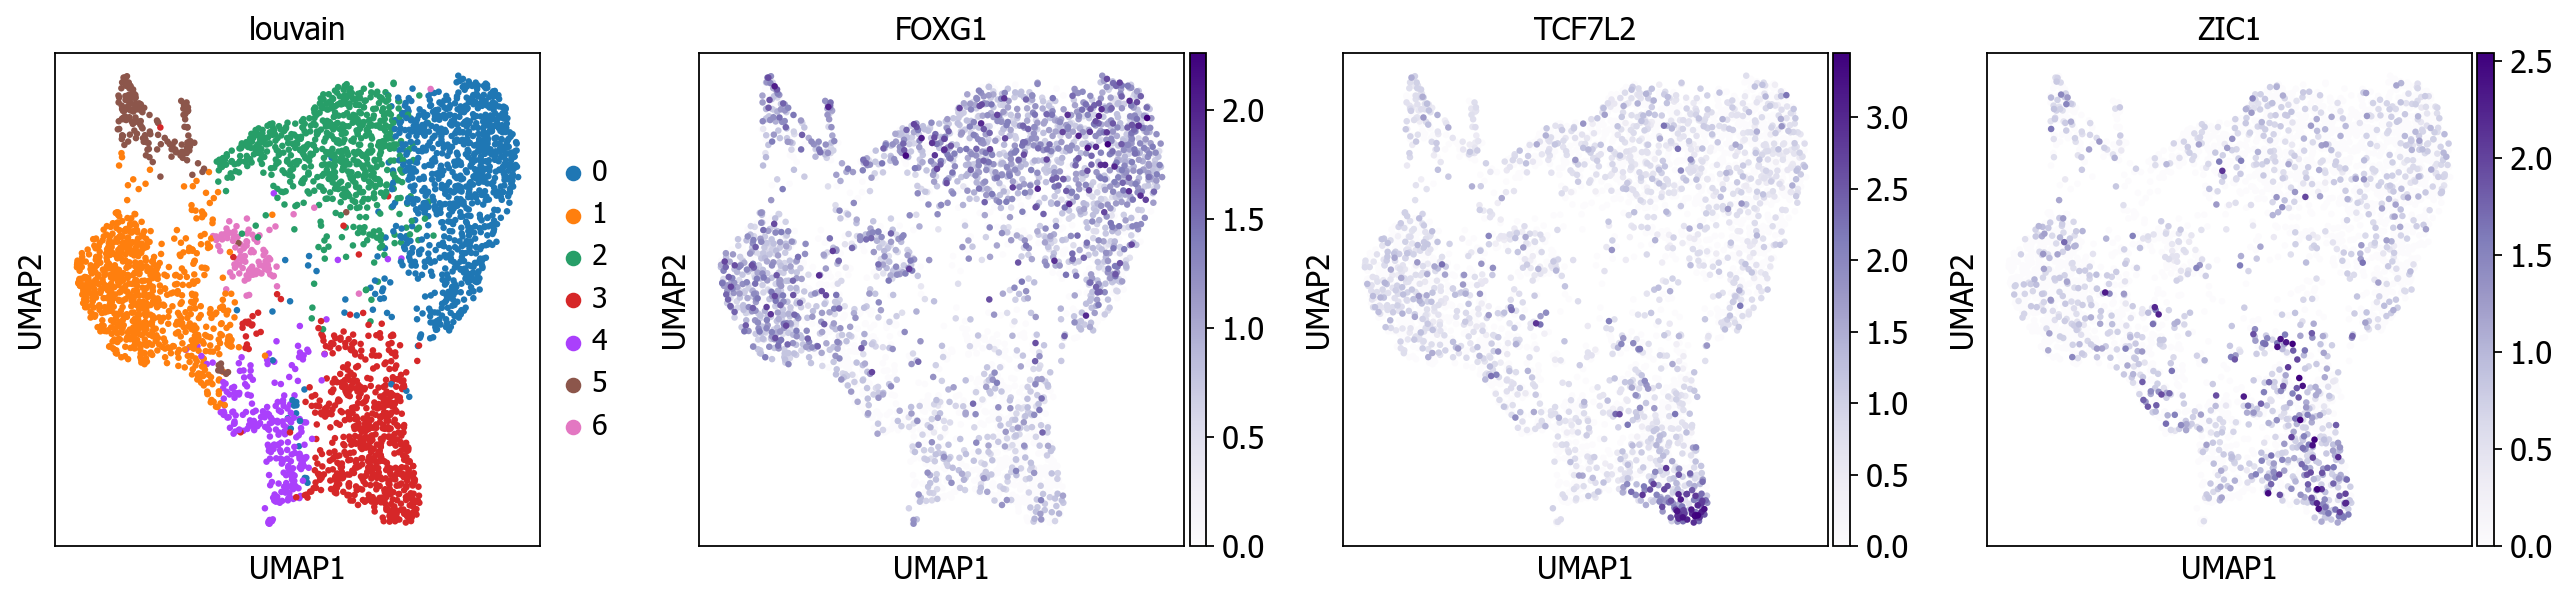

In [34]:
sc.pl.umap(adata, color=['louvain','FOXG1','TCF7L2','ZIC1'],color_map='Purples')#'RdPu')

In [352]:
cortical_cells = adata.obs[adata.obs['louvain'].isin(['0','1','2','5','6'])].index

In [353]:
adata = sc.read('/mnt/e/MPIMG/Elkabetz/scrna/d50_organoids/gene_counts/day50_exp1_2017_merged_counts.removed_dup_genes.csv',sep=',')

In [380]:
adata_cortical_cells = adata[cortical_cells,:]

In [383]:
pd.DataFrame.to_csv(adata_cortical_cells.obs,
                    '/mnt/e/MPIMG/Elkabetz/scrna/d50_organoids/Seurat_runs/cortical_cells_experiment1_cell_ident.csv',sep=',')

In [384]:
adata_exp2 = sc.read('/mnt/e/MPIMG/Elkabetz/data/scrna/d50_organoids/cortical_cells_count_matrix.csv')

In [388]:
adata_list = [adata_exp2,adata_cortical_cells]

In [391]:
adata_cortical_cells.var.index = [x.replace("-",".") for x in adata_cortical_cells.var.index]

In [394]:
overlapping_genes = sorted(list(set(adata_cortical_cells.var_names).intersection(set(adata_exp2.var_names))))

In [396]:
import copy
for j,adata in enumerate(adata_list):
    df=pd.DataFrame(adata.X)
    df.index=[x for x in adata.obs.index]
    df.columns=adata.var.index
    df = df[overlapping_genes] ## NOTE: here we subset to shared genes, don't do this if we want different genes as well
    if j == 0:
        merged_df = copy.deepcopy(df)
    else:
        merged_df = merged_df.append(df, sort=False)
merged_df
merged_df=merged_df.fillna(0)

In [398]:
pd.DataFrame.to_csv(merged_df,'/mnt/e/MPIMG/Elkabetz/data/scrna/d50_organoids/merged_exp1_exp2.cortical_only.overlapping_genes.csv',sep=',')

In [399]:
adata_merged = sc.read('/mnt/e/MPIMG/Elkabetz/data/scrna/d50_organoids/merged_exp1_exp2.cortical_only.overlapping_genes.csv')

Only considering the two last: ['.overlapping_genes', '.csv'].
Only considering the two last: ['.overlapping_genes', '.csv'].


In [400]:
batch = []
for x in adata_merged.obs.index:
    if 'batch' in x: batch.append('exp1')
    else: batch.append('exp2')
adata_merged.obs['batch'] = batch
adata_merged.obs

batch
sbn.bcBRVS        exp2
sbn.bcIJZH        exp2
sbn.bcDCLQ        exp2
sbn.bcDENH        exp2
sbn.bcCDLD        exp2
...                ...
batch2_cell_1289  exp1
batch2_cell_1291  exp1
batch2_cell_1292  exp1
batch2_cell_1293  exp1
batch2_cell_1294  exp1

[7691 rows x 1 columns]

In [401]:
sc.pp.filter_cells(adata_merged, min_genes=200)
sc.pp.filter_genes(adata_merged, min_cells=3)

In [402]:
adata_merged.obs

batch  n_genes
sbn.bcBRVS        exp2     2419
sbn.bcIJZH        exp2     2329
sbn.bcDCLQ        exp2     2374
sbn.bcDENH        exp2     2141
sbn.bcCDLD        exp2     2044
...                ...      ...
batch2_cell_1289  exp1     3812
batch2_cell_1291  exp1     2583
batch2_cell_1292  exp1     2792
batch2_cell_1293  exp1     3792
batch2_cell_1294  exp1     3168

[7691 rows x 2 columns]

In [403]:
adata_merged.X

array([[1., 0., 0., ..., 2., 0., 2.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 2., 2.],
       ...,
       [0., 0., 0., ..., 0., 2., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [404]:
sc.pp.normalize_total(adata_merged)
adata_merged.X = np.log1p(adata_merged.X)

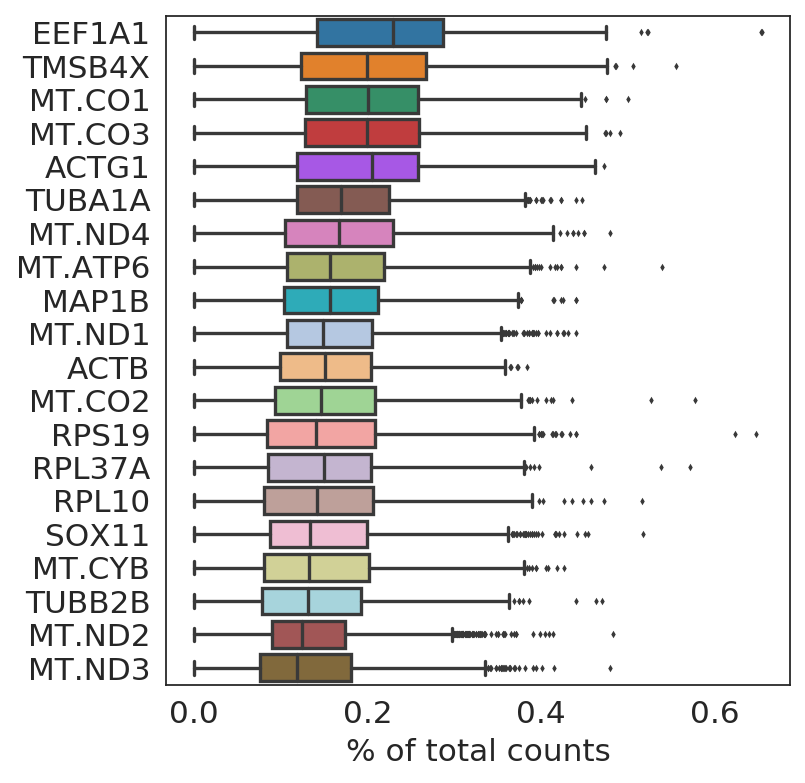

In [405]:
sc.pl.highest_expr_genes(adata_merged, n_top=20)

In [406]:
genes = adata_merged.var_names
mito_genes = [gene for gene in genes if gene[:3] == 'MT-' or (gene[:2] == 'MT' and '.' in gene)]
rb_genes = [gene for gene in genes if gene[:3] in ['RNR','RPL','RPS','MRP'] or (gene[:2] == 'RP' and '.' in gene)]

In [407]:
sc.pp.highly_variable_genes(adata_merged,n_bins=50)

In [408]:
min_mean = 0.0125
top_2000 = sorted(adata_merged.var['dispersions_norm'][adata_merged.var['means'] >= min_mean],reverse=True)[2000]
adata_merged.var['highly_variable'] = (adata_merged.var['dispersions_norm'] >= top_2000) & (adata_merged.var['means'] >= min_mean)
adata_merged.var

n_cells  highly_variable     means  dispersions  dispersions_norm
A2ML1       682            False  0.054492    -0.200736         -0.503906
AAAS       1242             True  0.156758     0.501157          1.090779
AACS       1034            False  0.115667     0.313736          0.155405
AADAT       698            False  0.065336     0.094289         -0.170210
AAGAB       721            False  0.062661     0.044261         -0.379332
...         ...              ...       ...          ...               ...
ZXDB        902            False  0.083164     0.071015         -0.267498
ZXDC        583            False  0.055724     0.174040          0.633692
ZYG11B     2152            False  0.250863     0.305479         -0.686261
ZYX        1185            False  0.131778     0.313302          0.153240
ZZEF1      1862            False  0.183432     0.001732         -2.096994

[11907 rows x 5 columns]

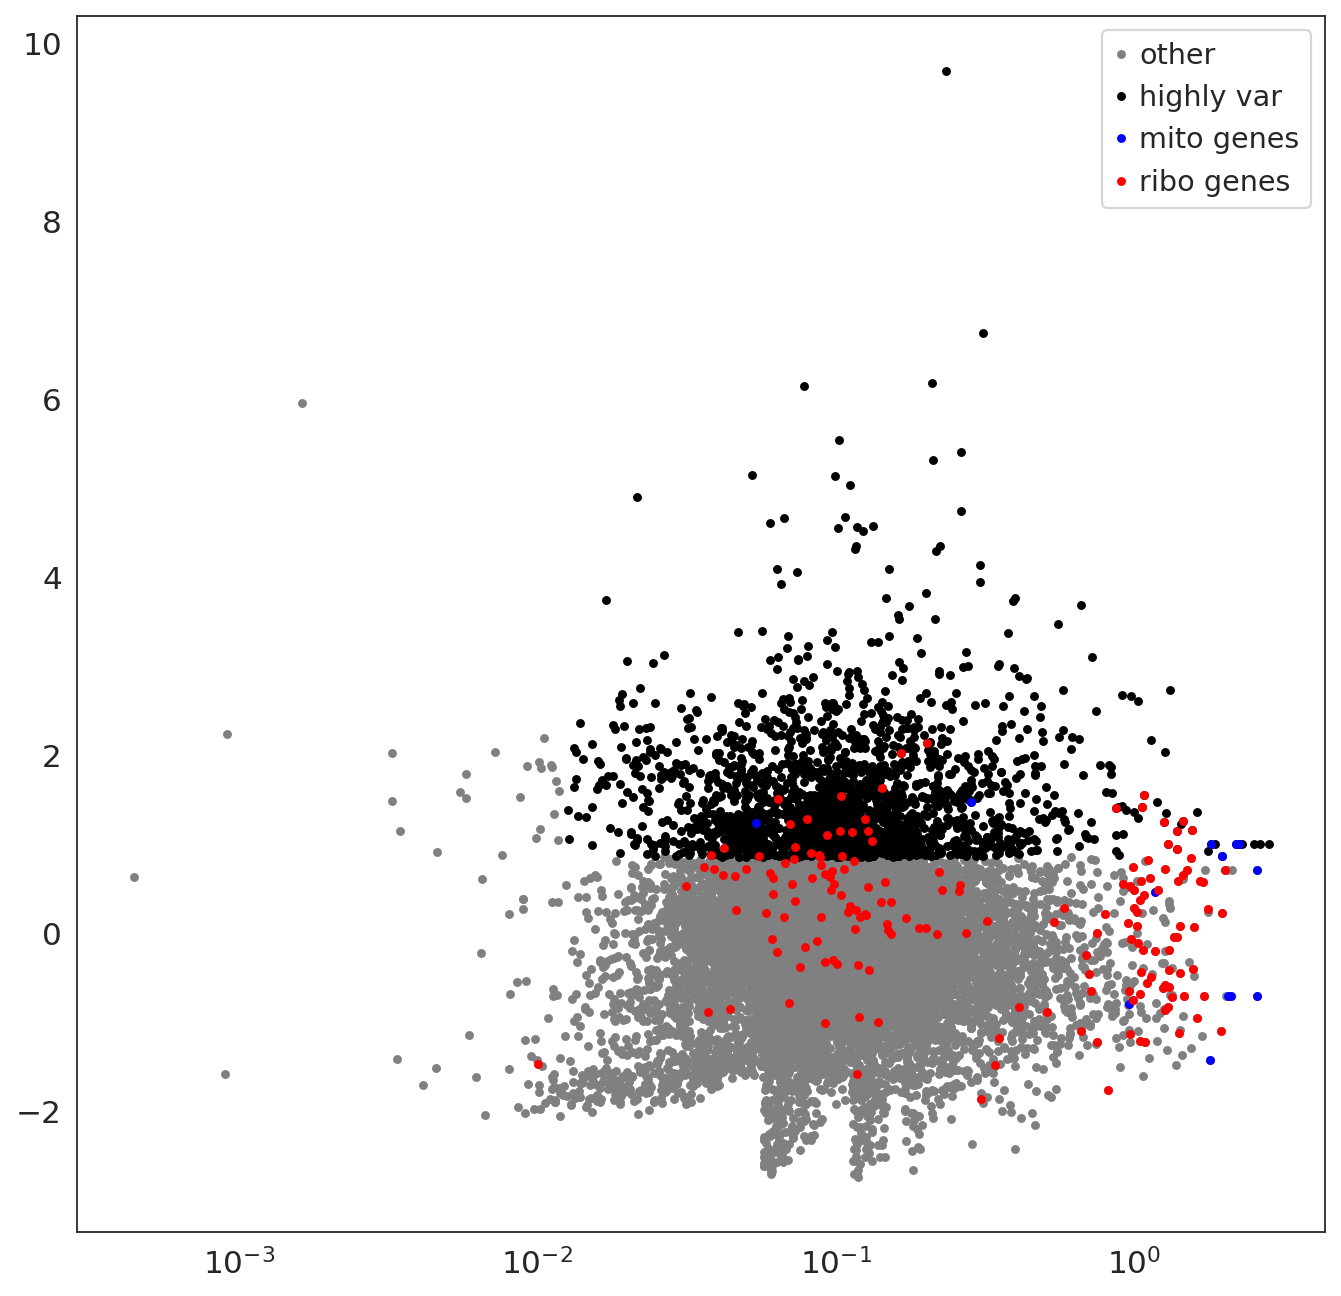

In [409]:
plt.figure(figsize=(10,10))
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == False]['means'],adata_merged.var[adata_merged.var['highly_variable'] == False]['dispersions_norm'],'.',color='gray',label='other')
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == True]['means'],adata_merged.var[adata_merged.var['highly_variable'] == True]['dispersions_norm'],'.',color='black',label='highly var')
plt.plot(adata_merged.var.loc[mito_genes]['means'],adata_merged.var.loc[mito_genes]['dispersions_norm'],'.',color='blue',label='mito genes')
plt.plot(adata_merged.var.loc[rb_genes]['means'],adata_merged.var.loc[rb_genes]['dispersions_norm'],'.',color='red',label='ribo genes')
plt.xscale('log')
plt.legend()

In [411]:
sc.tl.pca(adata_merged, svd_solver='arpack')

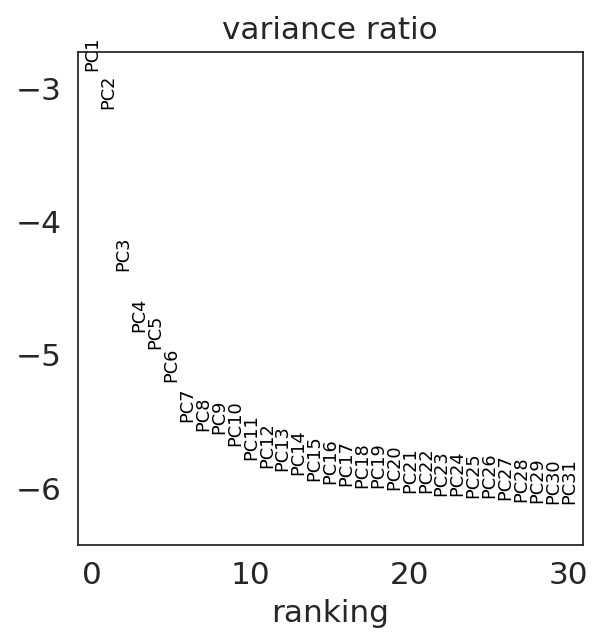

In [412]:
sc.pl.pca_variance_ratio(adata_merged,log=True)

... storing 'batch' as categorical


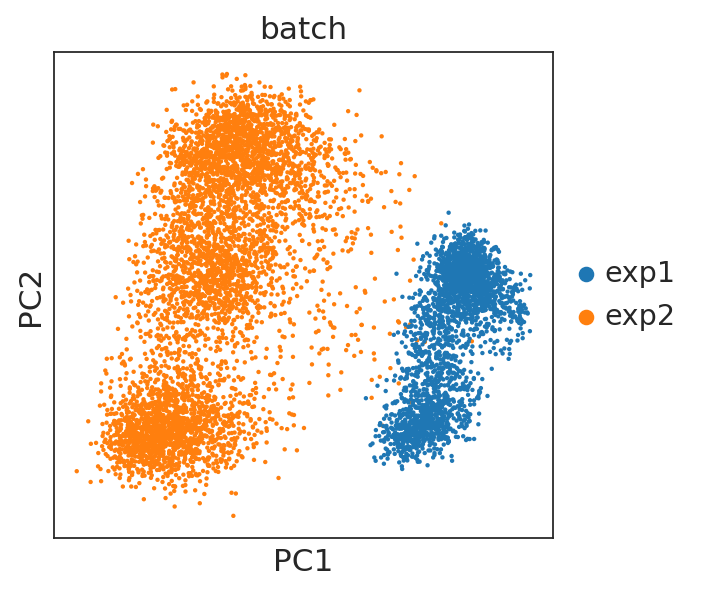

In [413]:
sc.pl.pca(adata_merged, color=['batch'])

In [414]:
sc.pp.combat(adata_merged,key='batch')

/home/rose/.local/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:235: RuntimeWarning: divide by zero encountered in true_divide
  b_prior[i],


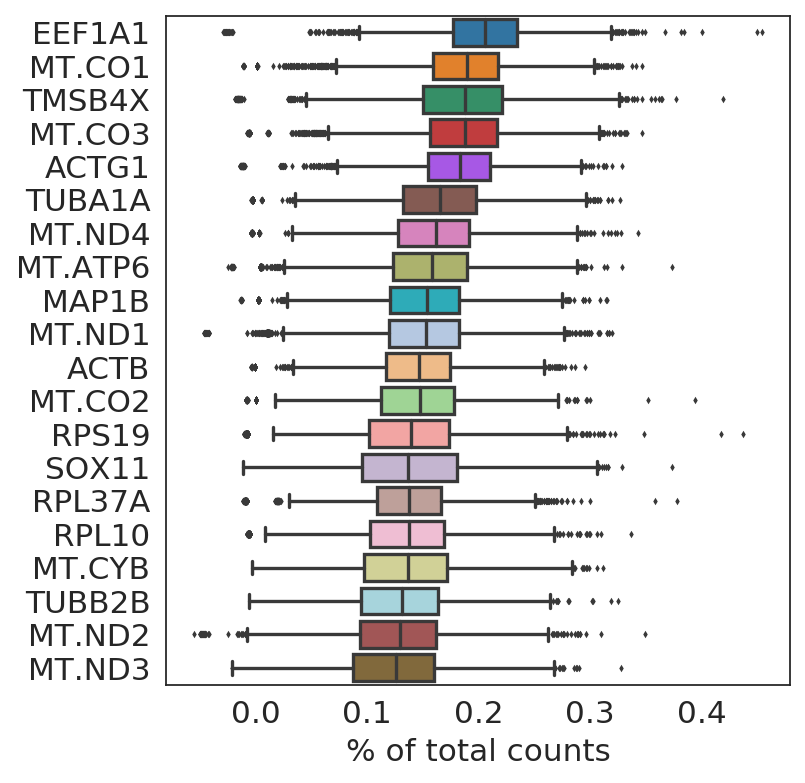

In [415]:
sc.pl.highest_expr_genes(adata_merged, n_top=20)

In [416]:
sc.pp.highly_variable_genes(adata_merged,n_bins=50)

In [417]:
min_mean = 0.0125
top_2000 = sorted(adata_merged.var['dispersions_norm'][adata_merged.var['means'] >= min_mean],reverse=True)[2000]
adata_merged.var['highly_variable'] = (adata_merged.var['dispersions_norm'] >= top_2000) & (adata_merged.var['means'] >= min_mean)
adata_merged.var

n_cells  highly_variable     means  dispersions  dispersions_norm
A2ML1       682            False  0.054942     0.079684         -0.524538
AAAS       1242            False  0.154505     0.356913         -0.043937
AACS       1034            False  0.114545     0.200888         -0.240616
AADAT       698            False  0.065188     0.113117         -0.392734
AAGAB       721            False  0.062974     0.231017         -0.238974
...         ...              ...       ...          ...               ...
ZXDB        902            False  0.083150     0.196721         -0.283702
ZXDC        583            False  0.055544     0.170306         -0.318150
ZYG11B     2152            False  0.248652     0.226411         -0.253636
ZYX        1185            False  0.130630     0.236605         -0.195593
ZZEF1      1862            False  0.178705     0.134451         -0.319649

[11907 rows x 5 columns]

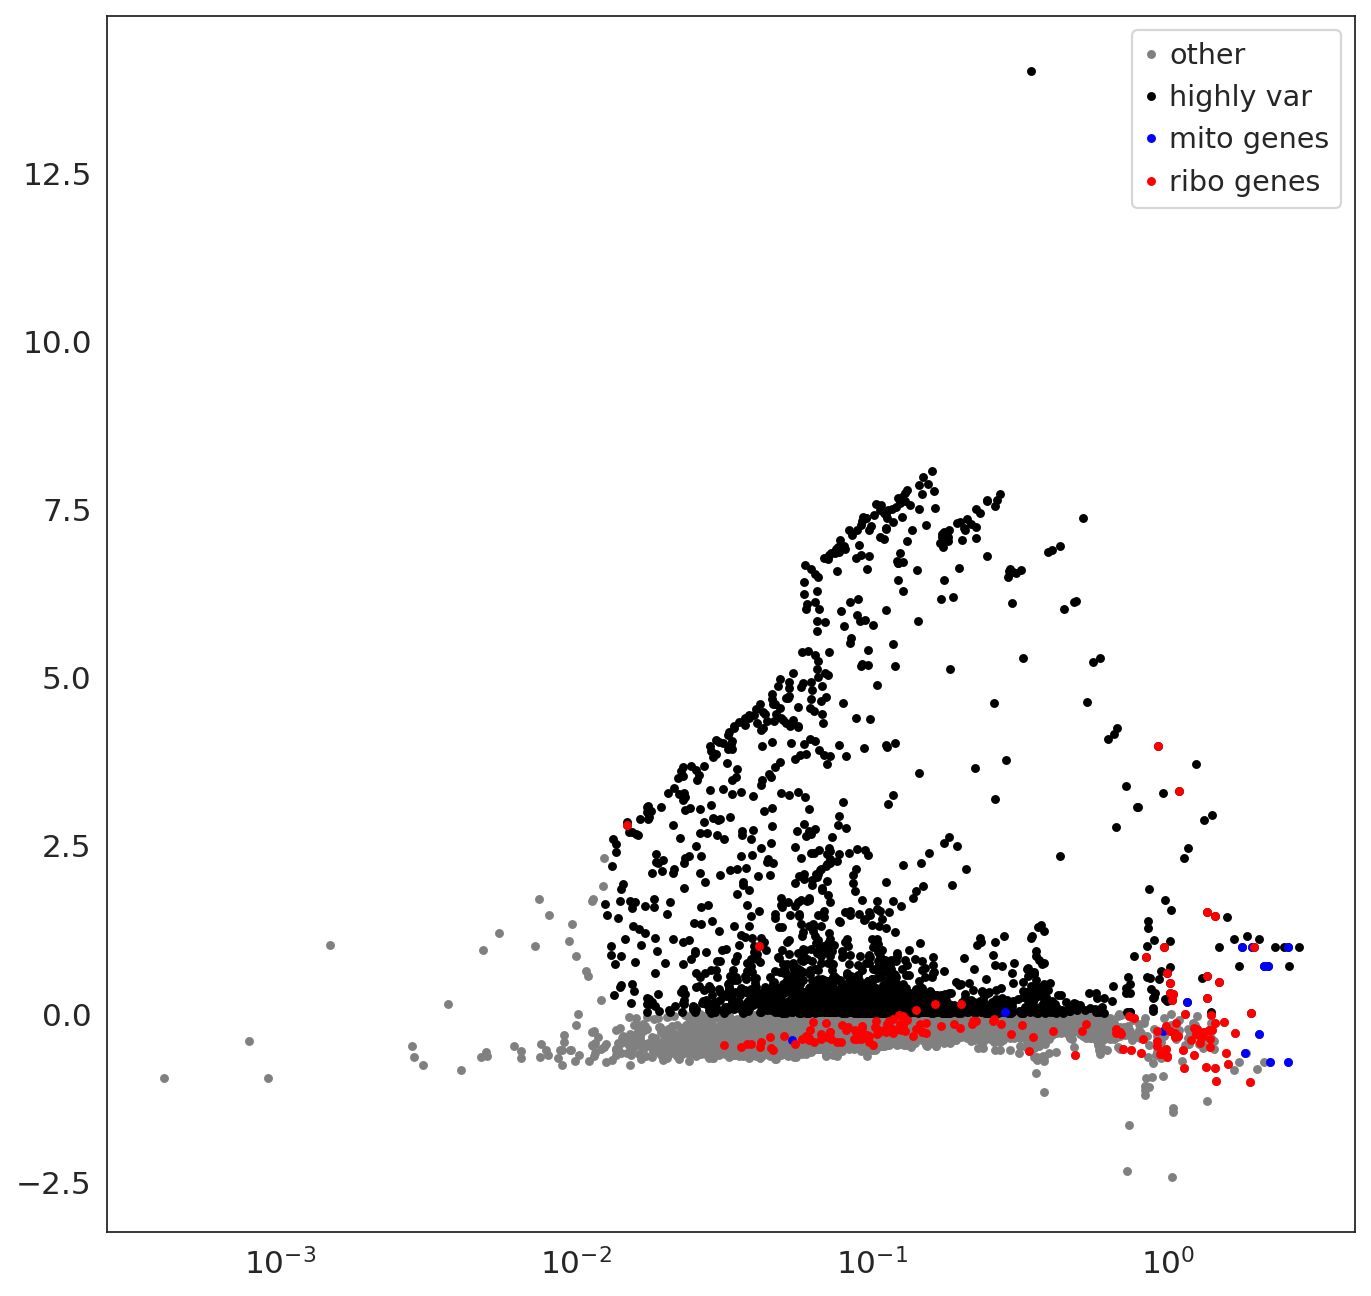

In [418]:
plt.figure(figsize=(10,10))
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == False]['means'],adata_merged.var[adata_merged.var['highly_variable'] == False]['dispersions_norm'],'.',color='gray',label='other')
plt.plot(adata_merged.var[adata_merged.var['highly_variable'] == True]['means'],adata_merged.var[adata_merged.var['highly_variable'] == True]['dispersions_norm'],'.',color='black',label='highly var')
plt.plot(adata_merged.var.loc[mito_genes]['means'],adata_merged.var.loc[mito_genes]['dispersions_norm'],'.',color='blue',label='mito genes')
plt.plot(adata_merged.var.loc[rb_genes]['means'],adata_merged.var.loc[rb_genes]['dispersions_norm'],'.',color='red',label='ribo genes')
plt.xscale('log')
plt.legend()

In [421]:
sc.tl.pca(adata_merged, svd_solver='arpack')

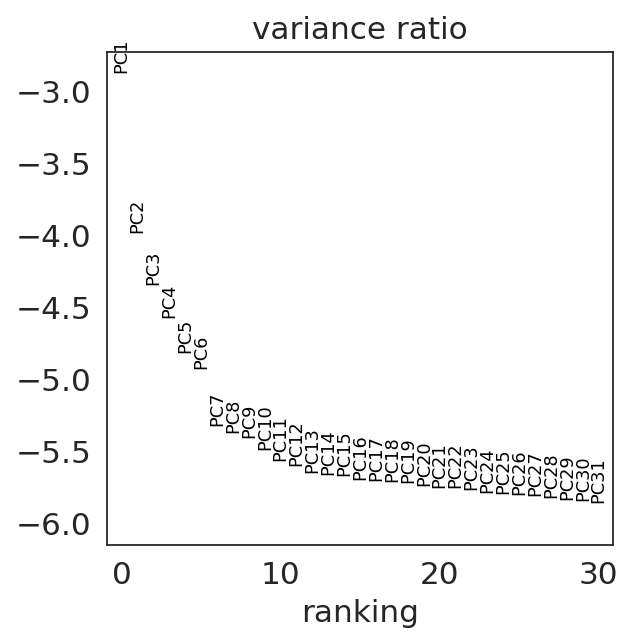

In [422]:
sc.pl.pca_variance_ratio(adata_merged,log=True)

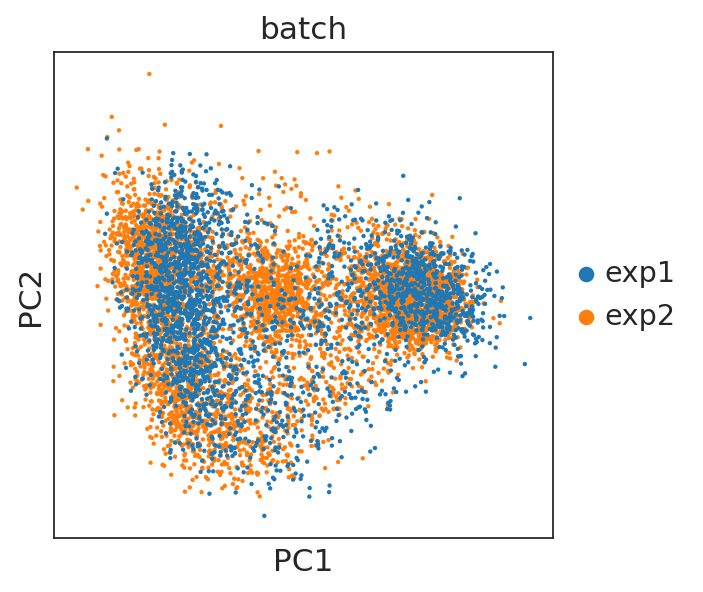

In [423]:
sc.pl.pca(adata_merged, color=['batch'])

In [424]:
sc.pp.neighbors(adata_merged)#, method='gauss', n_neighbors=100, n_pcs=12)

In [425]:
sc.tl.umap(adata_merged)#,min_dist=1,spread=5)

In [426]:
sc.tl.louvain(adata_merged,)

In [427]:
# load Seurat clusters and set to cluster in obs
cell_ident_df = pd.read_csv("/mnt/e/MPIMG/Elkabetz/scrna/d50_organoids/Seurat_runs/cortical_cells_d50_cell_ident.txt",sep='\t')
int(cell_ident_df[cell_ident_df['cell'] == 'sbnx.bcHTPM']['cluster'])

1

In [429]:
adata_merged.obs['index'] = range(len(adata_merged.obs))

In [433]:
### assign based on max correlation across cluster
adata_exp2.obs['index'] = range(len(adata_exp2.obs))
adata_exp2.var['index'] = range(len(adata_exp2.var))
adata_merged.var['index'] = range(len(adata_merged.var))
adata_cortical_cells.var.index = [x.replace("-",".") for x in adata_cortical_cells.var.index]
adata_cortical_cells.var['index'] = range(len(adata_cortical_cells.var))
adata_cortical_cells.obs['index'] = range(len(adata_cortical_cells.obs))

Trying to set attribute `.var` of view, making a copy.


In [436]:
from scipy.stats import pearsonr

In [255]:
marker_genes_df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/markers.all.sbnx_sbn_nt.csv',sep=',')
marker_genes = set(marker_genes_df['gene'])
marker_genes = marker_genes.intersection(set(adata_merged.var.index))
marker_genes = list(marker_genes)

In [452]:
cluster_profiles = {}
for cluster in set(cell_ident_df['cluster']):
    clust_cells = adata_merged.X[:,adata_merged.var.loc[adata_merged.var.index]['index']][adata_merged.obs.loc[cell_ident_df[cell_ident_df['cluster']==cluster]['cell']]['index'],:]
    cluster_profiles[cluster] = clust_cells.mean(axis=0)
    
    #clust_cells = adata_merged.X[:,adata_merged.var.loc[marker_genes]['index']][adata_merged.obs.loc[cell_ident_df[cell_ident_df['cluster']==cluster]['cell']]['index'],:]
    #cluster_profiles[cluster] = clust_cells.mean(axis=0)

In [453]:
corr_dict = {}
for j,cell_profile in enumerate(adata_merged.X[:,adata_merged.var.loc[adata_merged.var.index]['index']]):
    #for j,cell_profile in enumerate(adata_merged.X[:,adata_merged.var.loc[adata_merged.var.index]['index']]):
    if 'batch' not in adata_merged.obs.index[j]: continue
    print(j)
    corr_dict[adata_merged.obs.index[j]] = {}
    for clust in cluster_profiles:
        corr, _ = pearsonr(cell_profile, cluster_profiles[clust])
        corr_dict[adata_merged.obs.index[j]][clust] = corr

5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290


6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953


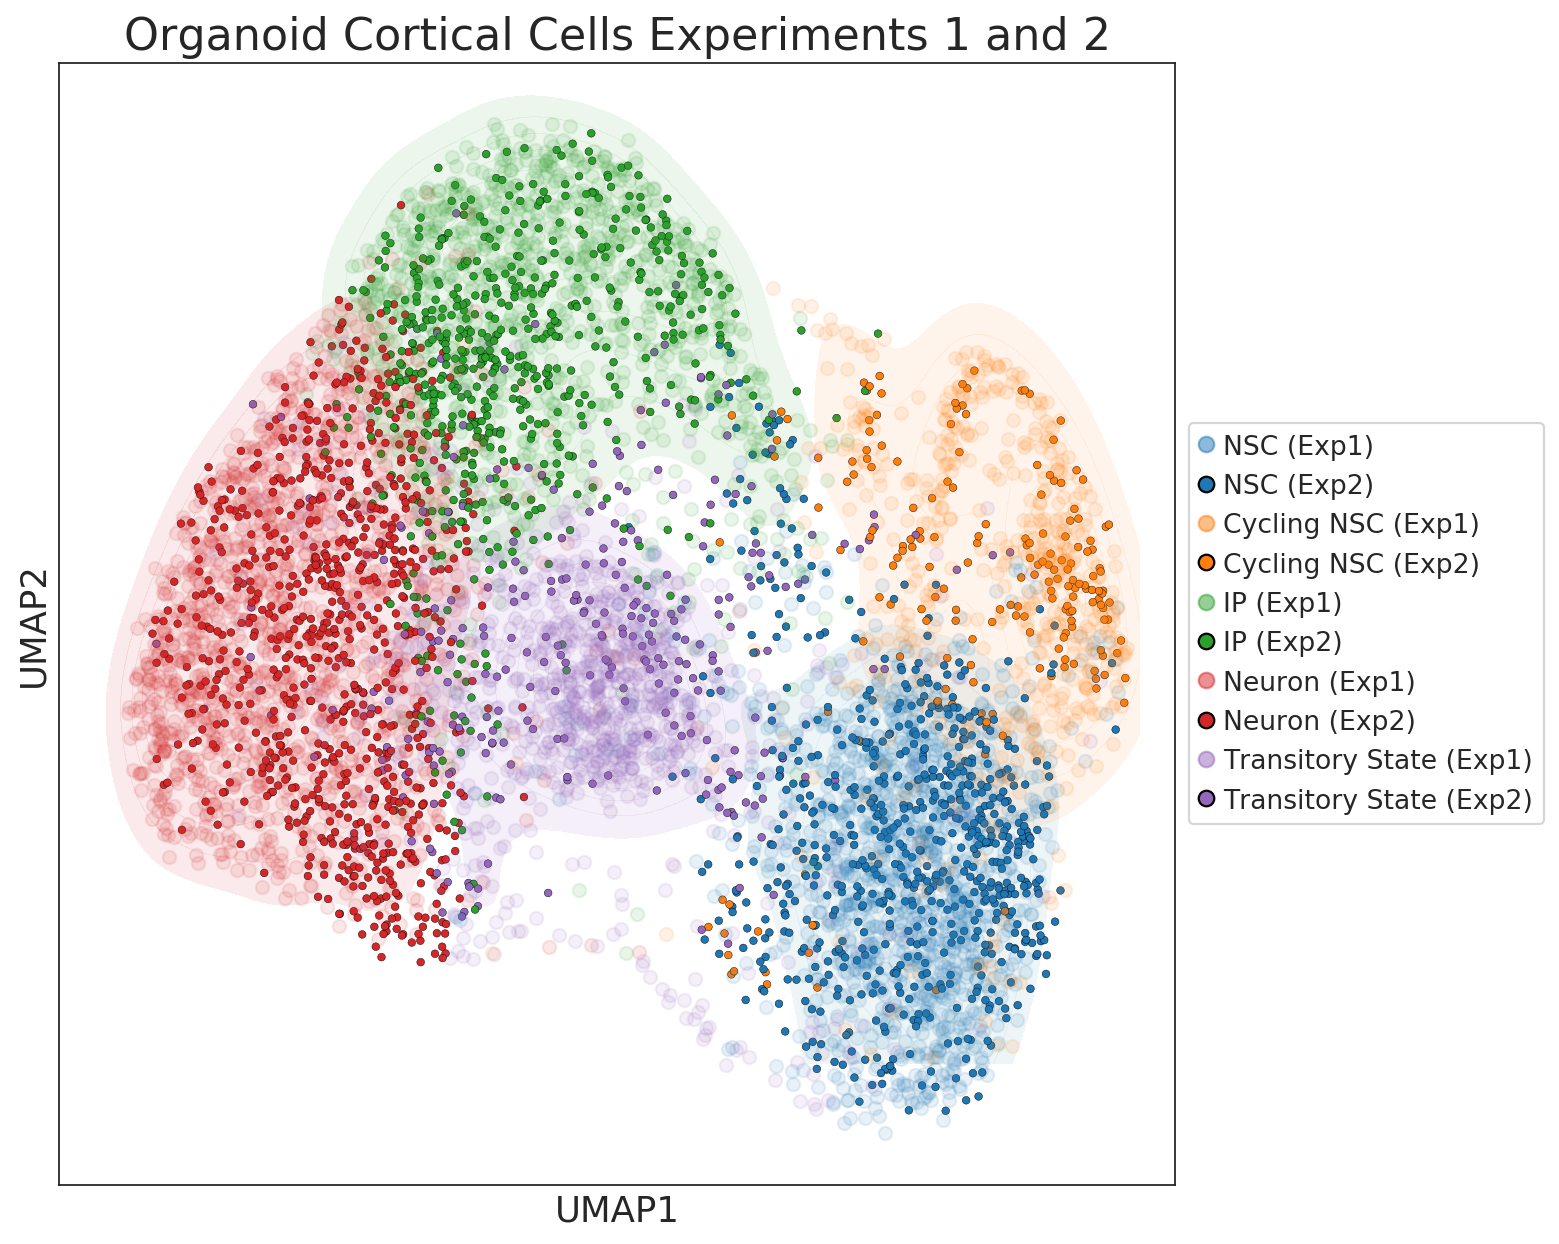

In [454]:
sns.set_style('white')
plt.figure(figsize=(10,8))
ax=plt.subplot(111)

delta = 0.1
x_bin = np.arange(-10, 5, delta)
y_bin = np.arange(-2,6.5, delta)
X, Y = np.meshgrid(x_bin, y_bin)
n_levels = 8


for cluster in set(cell_ident_df['cluster']):
    dat = adata_merged.obsm['X_umap'][adata_merged.obs.loc[cell_ident_df[cell_ident_df['cluster']==cluster]['cell']]['index']]
    x = dat[:,0]
    y = dat[:,1]
    
    plt.plot(x,y,'o',color=clrs[cluster-1],alpha=0.1)
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    level_colors = [clrs[cluster-1]]*(n_levels-1)
    level_colors.insert(0,'white')
    plt.contourf(X, Y, Z, n_levels, colors=level_colors,alpha=0.1)
    
xs = [[],[]]
ys = [[],[]]
final_colors = [[],[]]

for j,cell in enumerate(adata_merged.obs.index):
    #final_colors.append(clrs[int(cell)])
    if 'batch' in cell:
        #final_colors[1].append('gray')
        final_colors[1].append(clrs[max(corr_dict[cell].items(),key = lambda x:x[1])[0]-1])
        xs[1].append(adata_merged.obsm['X_umap'][j,0])
        ys[1].append(adata_merged.obsm['X_umap'][j,1])

plt.scatter(xs[1],ys[1],c=final_colors[1],s=12,alpha=1,edgecolor='black',linewidth=0.2)
plt.xlim((plt.xlim()[0],plt.xlim()[1]+0.5))
plt.ylim((plt.ylim()[0],plt.ylim()[1]+0.2))

#plt.plot(adata_merged.obsm['X_umap'][0,0],adata_merged.obsm['X_umap'][0,1],'.',markersize=10,color='black')

for (clust,lab) in zip(sorted(map(int,set(range(5)))),['NSC','Cycling NSC','IP','Neuron','Transitory State']):
    plt.plot(-10000,-10000,'.',color=clrs[int(clust)],label=lab+' (Exp1)',markersize=14,alpha=0.5)
    plt.plot(-10000,-10000,'.',color=clrs[int(clust)],label=lab+' (Exp2)',markeredgecolor='black',linewidth=0.1,
             markersize=14)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width , box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

plt.xlabel('UMAP1',fontsize=16)
plt.ylabel('UMAP2',fontsize=16)
plt.title('Organoid Cortical Cells Experiments 1 and 2',fontsize=20)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/umap_cortical_cells_merged.pdf')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/umap_cortical_cells_merged.png',dpi=500)

In [461]:
exp1_nums = {}
sbnx_dub_df = cell_ident_df[cell_ident_df['cell'].str.contains('sbnx')]
for cluster in set(sbnx_dub_df['cluster']):
    exp1_nums[cluster] = len(sbnx_dub_df[sbnx_dub_df['cluster'] == cluster])

exp2_nums = {}
for cluster in set(sbnx_dub_df['cluster']):
    exp2_nums[cluster] = 0
    
for j,cell in enumerate(adata_merged.obs.index):
    #final_colors.append(clrs[int(cell)])
    if 'batch' in cell:
        #final_colors[1].append('gray')
        exp2_nums[max(corr_dict[cell].items(),key = lambda x:x[1])[0]] += 1

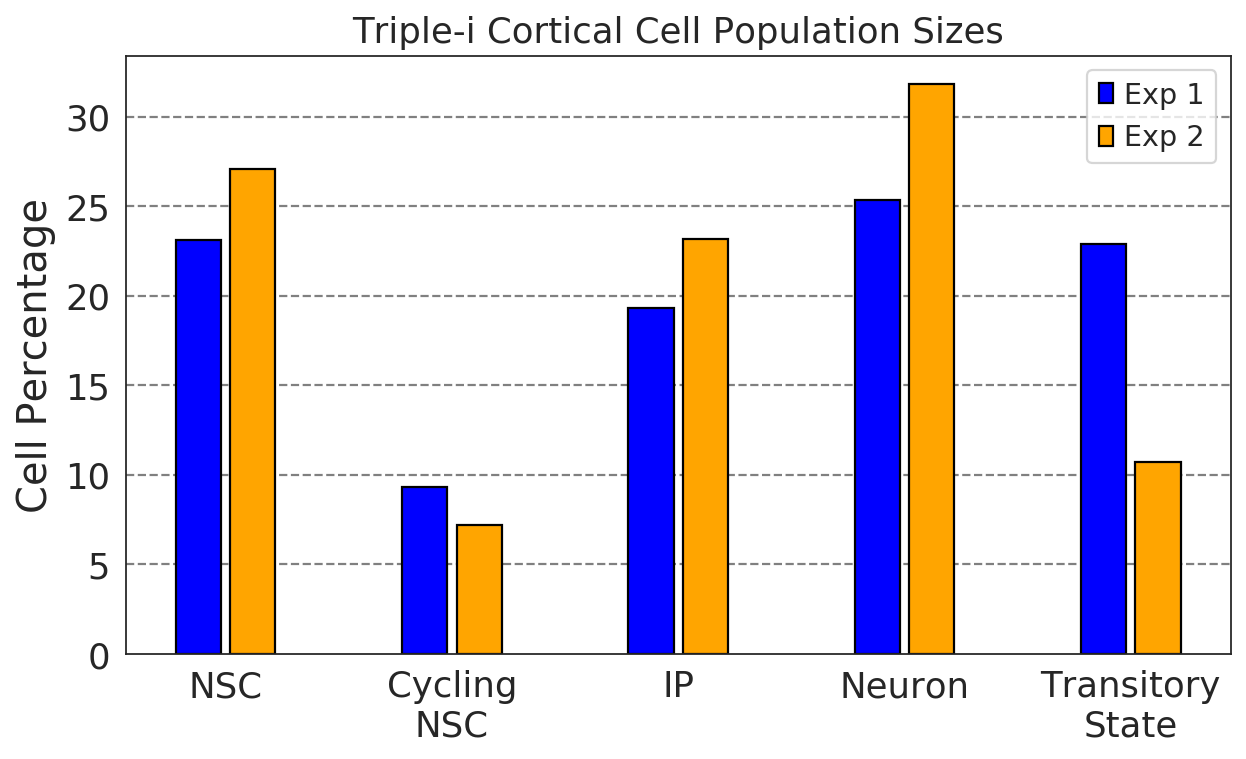

In [462]:
plt.figure(figsize=(8,5))
for h in [0.05,0.1,0.15,0.2,0.25,0.3]:
    plt.axhline(h,color='gray',zorder=0,linewidth=1,linestyle='--')
plt.bar([x-0.02 for x in sorted(exp1_nums.keys())],[exp1_nums[x]/float(sum(list(exp1_nums.values()))) for x in sorted(exp1_nums.keys())],width=0.2,edgecolor='black',color='blue')
plt.bar([x+0.22 for x in sorted(exp2_nums.keys())],[exp2_nums[x]/float(sum(list(exp2_nums.values()))) for x in sorted(exp2_nums.keys())],width=0.2,edgecolor='black',color='orange')
plt.xticks([x+0.1 for x in range(1,6)],['NSC','Cycling\nNSC','IP','Neuron','Transitory\nState'],fontsize=16)
plt.ylabel('Cell Percentage',fontsize=18)
plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3],['0','5','10','15','20','25','30'],fontsize=16)
plt.xlim(plt.xlim())
plt.bar(100,0,width=2,edgecolor='black',color='blue',label='Exp 1')
plt.bar(100,0,width=2,edgecolor='black',color='orange',label='Exp 2')
plt.legend()
plt.title('Triple-i Cortical Cell Population Sizes',fontsize=16)
plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/cortical_cell_pop_sizes.pdf')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/cortical_cell_pop_sizes.png',dpi=500)